Multipole Decomposition
====================================

**New in v1.0.8.**

**CAUTION: this is a beta-functionality which has not yet been tested in a sufficient number of different scenarios. While it is supposed to work correctly in vacuum, there are still doubts about the results in non-vacuum environment cases.**

Here we demonstrate the multipole decomposition of the fields and the extinction spectra of arbitrary shaped nanostructures. The implementation in pyGDM is following reference [1].

In this example we reproduce the case of a silicon nano-cube with side-length 160nm in vacuum, shown in figure 3a of reference [1].


[1] Evlyukhin, A. B., Reinhardt, C. and Chichkov, B. N. *Multipole light scattering by nonspherical nanoparticles in the discrete dipole approximation*. **Phys. Rev. B** 84, 235429 (2011)

Simulation setup
--------------------

In [1]:
from __future__ import print_function, division

## --- load the modules
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import visu
from pyGDM2 import tools
from pyGDM2 import linear


Config and run simulation
-------------------------------------

Si nanocube of 160 nm side-length in vacuum, plane wave illumination. 

We discretize with 10 nm to achieve a relatively fast inversion for this demonstration.

/home/hans/.local/lib/python2.7/site-packages/pyGDM2-rc1.0.8-py2.7-linux-x86_64.egg/pyGDM2/structures.py:110: UserWarning: Minimum structure Z-value lies below substrate level! Shifting structure bottom to Z=step/2.


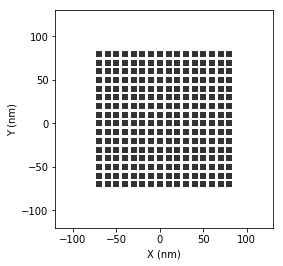

N dp=4096
timing 530.00nm - inversion: 51582.5 ms,repropagation: 153.8ms (1 field configs), total: 51736.6 ms
timing 540.00nm - inversion: 64199.2 ms,repropagation: 154.4ms (1 field configs), total: 64353.7 ms
timing 550.00nm - inversion: 71262.7 ms,repropagation: 321.1ms (1 field configs), total: 71584.0 ms
timing 560.00nm - inversion: 71602.7 ms,repropagation: 330.6ms (1 field configs), total: 71933.5 ms
timing 570.00nm - inversion: 79231.2 ms,repropagation: 319.8ms (1 field configs), total: 79551.2 ms
timing 580.00nm - inversion: 72053.9 ms,repropagation: 164.1ms (1 field configs), total: 72218.1 ms
timing 590.00nm - inversion: 79732.7 ms,repropagation: 153.1ms (1 field configs), total: 79885.9 ms
timing 600.00nm - inversion: 71118.2 ms,repropagation: 322.0ms (1 field configs), total: 71440.5 ms
timing 610.00nm - inversion: 78114.1 ms,repropagation: 335.4ms (1 field configs), total: 78449.7 ms
timing 620.00nm - inversion: 75096.7 ms,repropagation: 323.0ms (1 field configs), total: 7

In [2]:
## --- simulation initialization ---
mesh = 'cube'
step = 10
geometry = structures.rect_wire(step, L=int(np.round(160/step)), 
                                      W=int(np.round(160/step)), 
                                      H=int(np.round(160/step)), mesh=mesh)
material = materials.silicon()
norm = structures.get_normalization(mesh=mesh)
n1 = n2 = n3 = 1.0

struct = structures.struct(step, geometry, material, n1,n2, norm, n3=n3)

## incident field: lin. pol plane wave
field_generator = fields.planewave
wavelengths = np.linspace(530,830,31)
kwargs = dict(theta=0.0, kSign=-1)
efield = fields.efield(field_generator, 
               wavelengths=wavelengths, kwargs=kwargs)

## create simulation object
sim = core.simulation(struct, efield)

visu.structure(sim)
print("N dp={}".format(len(geometry)))


## --- run the main simulation ---
core.scatter(sim, method='lu')


Extinction spectra
----------------------------------------------

Now we calculate the multipole decomposition of the extinction and compare it to the extinction spectrum obtained from the full discretization. Note that the blue-most resonance around 550nm is mainly electric-octupole (see PRB 84 235429, 2011), hence not contained in our decomposition into dipole and quadrupole moments.

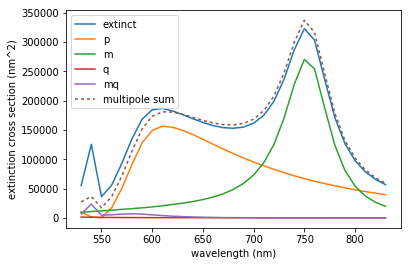

In [3]:
## -- spectra of extinction sections per multipole moment
wl, spec1 = tools.calculate_spectrum(sim, 0, linear.extinct)
ex, sc, ab = spec1.T
wl, spec2 = tools.calculate_spectrum(sim, 0, linear.mutlipole_decomp_extinct)
ex_p, ex_m, ex_q, ex_mq = spec2.T


plt.plot(wl, ex, label='extinct')
plt.plot(wl, ex_p, label='p')
plt.plot(wl, ex_m, label='m')
plt.plot(wl, ex_q, label='q')
plt.plot(wl, ex_mq, label='mq')
plt.plot(wl, ex_p + ex_m + ex_q + ex_mq, label='multipole sum', dashes=[2,2])

plt.legend()
plt.xlabel("wavelength (nm)")
plt.ylabel("extinction cross section (nm^2)")
plt.show()

plot the main contributing dipole moments
------------------------------------------------------

We set linear $X$ polarized, plane wave illumination, so we expect the electric dipole moment to be mainly oriented along $X$ and the magnetic dipole moment mainly along $Y$ (incidence along $Z$). This can be easily confirmed by the multipole decomposition:

*Note:* the dipole moments are determined by the arbitrarily chosen incident field amplitude (in pyGDM usually "1").

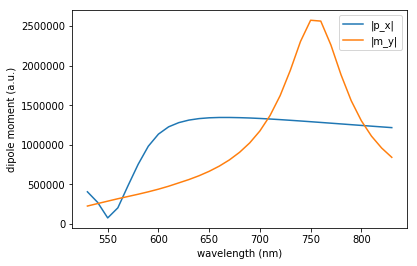

In [4]:
## -- spectra of multipole moments
wl, spec_dpdecomp = tools.calculate_spectrum(sim, 0, linear.mutlipole_decomp)
p = np.array([decomp[0] for decomp  in spec_dpdecomp])
m = np.array([decomp[1] for decomp  in spec_dpdecomp])

plt.plot(wl, np.abs(p.T[0]), label='|p_x|')
plt.plot(wl, np.abs(m.T[1]), label='|m_y|')
plt.legend()
plt.xlabel("wavelength (nm)")
plt.ylabel("dipole moment (a.u.)")
plt.show()